This is Part 2 of a 3 part series on [Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network).

[Part 1](https://beckernick.github.io/convolutions/) detailed the basics of image convolution. This post will detail the basics of standard neural networks with hidden layers. As in the last post, I'll implement the code in both standard Python and TensorFlow.

Let me say at the outset that this post will be similar to several other posts by a few people walking through neural networks (Google's Tensorflow tutorials, Andrej Karpathy's lecture notes, and others's posts). This somewhat begs the question: why make this post?.

The main reason is that doing this on my own will **signifcantly** improve my understanding of neural networks. By actually trying to build a neural network from scratch, I went from a general, high-level understanding of neural networks to a detailed, low-level understanding.

The secondary reason is that, if I phrase things slightly differently and someone is able to understand neural networks a little better by reading this in addition to the other (vastly superior) resources, this was worth putting out there.

Okay. Enough introduction. Time to briefly and poorly explain what neural networks are, generate some data, and start building a neural network.

# What is a Neural Network?

I think a good way to think of a neural network is as a multi-layered decision system. Information is fed into the network, manipulated and transformed, then fed into the second layer, manipulated and transformed again, and so on until a decision is made after the final transformation. The key to the network, then, is figuring out effective manipulations and transformations of the data to get good decisions.

Decades of research have produced some pretty amazing insights into how we might want to manipulate and transform the data. Though neural networks have been around for a while, they went out of fashion for a couple of decades. A key insight that helped bring them back into the fold was a clever way to efficiently determine effective manipulations and transformations.

Now, the research field is more active than ever before. People are developing unbelievably effective and advanced networks for tons of problems. I won't cover any advanced networks in this post, but there are sophisticated networks powering a good chunk of the technology we use today.

Before designing a network, though, I need some data to play with.

# Generating Data

To start off, I'll create a dataset with several mostly separable clusters of points. Though how clear the clusters are doesn't really affect how I'm going to build the network, my ego makes me want to ultimately have a successful model. I can easily generate random clusters of data by sampling from a multivariate normal distribution centered at different points. I'll use difference covariance matrices just because it's more fun.

In [191]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

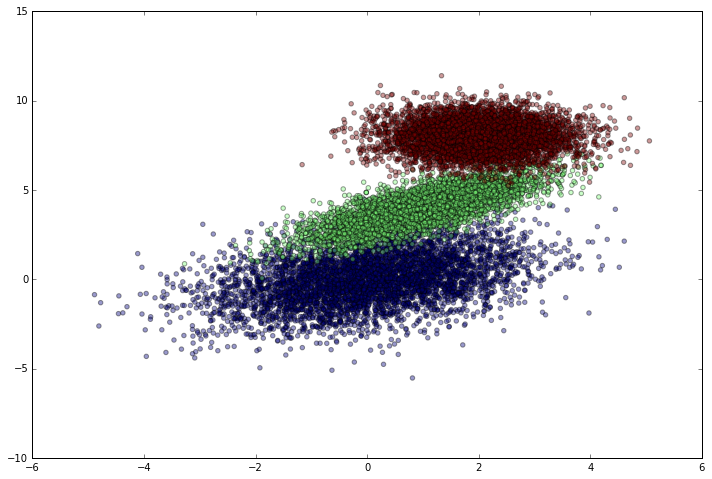

In [192]:
np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
x3 = np.random.multivariate_normal([2, 8], [[0, .75],[.75, 0]], num_observations)

simulated_separableish_features = np.vstack((x1, x2, x3)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations), np.ones(num_observations) + 1))

plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)

Okay, so the dataset looks good. Time to get it ready for tensorflow.

## Data Preparation

Since I'm using simulated data, I don't have to do any data cleaning and I barely have to do any prep. Tensorflow expects each feature label to be a one-hot encoded vector, so I'll reformat `simulated_labels`. Then I'll create a training and test set so we can see how well the model generalizes to unseen data.

In general, I would want train a predictive model with a validation dataset or by doing cross-validation. But, since I'm not going to be tuning any hyperparameters in this example, I'm not that worried about it.

In [209]:
labels_onehot = np.zeros((simulated_labels.shape[0], 3)).astype(int)
labels_onehot[np.arange(len(simulated_labels)), simulated_labels.astype(int)] = 1

train_dataset, test_dataset, \
train_labels, test_labels = train_test_split(
    simulated_separableish_features, labels_onehot, test_size = .1, random_state=12)

With the data split, it's time to train the model.

# Building a Neural Network in Tensorflow

In Tensorflow, there are two high level steps to in building a network:

1. Setting up the graph.
2. Executing the graph to train the model.

I'm not going to walk through every step of this code, since the focus of this post is building the network without Tensorflow. However, my Tensorflow model was based on one of the modules from the Udacity course on Deep Learning with Tensorflow. I would highly encourage anyone curious about Tensorflow to check it out.

To classify my data, I'm going to build a neural network with three layers: an input layer, a hidden layer, and an output layer. The following code sets up my neural network with 5 neurons in the hidden layer.

In [194]:
hidden_nodes = 5
num_labels = train_labels.shape[1]
batch_size = 100
num_features = train_dataset.shape[1]
learning_rate = .01

graph = tf.Graph()
with graph.as_default():
    
    # Data
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, num_features])
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels])
    tf_test_dataset = tf.constant(test_dataset)
  
    # Weights and Biases
    layer1_weights = tf.Variable(tf.truncated_normal([num_features, hidden_nodes]))
    layer1_biases = tf.Variable(tf.zeros([hidden_nodes]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    layer2_biases = tf.Variable(tf.zeros([num_labels]))
    
    # Three-Layer Network
    def three_layer_network(data):
        input_layer = tf.matmul(data, layer1_weights)
        hidden = tf.nn.relu(input_layer + layer1_biases)
        output_layer = tf.matmul(hidden, layer2_weights) + layer2_biases
        return output_layer
    
    # Model Scores
    model_scores = three_layer_network(tf_train_dataset)
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(model_scores, tf_train_labels))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(model_scores)
    test_prediction = tf.nn.softmax(three_layer_network(tf_test_dataset))

With the network set up, I can now train it in batches with mini batch gradient descent (or with full passes over the data). Since I want to pass multiple times over the data, I'll define an offset variable that will let me partition the data into mini batches and wrap around to the beginning again. I also need an accuracy function to take probabilities and one hot encoded label arrays, so I'll define that, too.

In [195]:
def accuracy(predictions, labels):
    preds_correct_boolean =  np.argmax(predictions, 1) == np.argmax(labels, 1)
    correct_predictions = np.sum(preds_correct_boolean)
    accuracy = 100.0 * correct_predictions / predictions.shape[0]
    return accuracy

In [197]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        minibatch_data = train_dataset[offset:(offset + batch_size), :]
        minibatch_labels = train_labels[offset:(offset + batch_size)]
        
        feed_dict = {tf_train_dataset : minibatch_data, tf_train_labels : minibatch_labels}
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict = feed_dict
            )
        
        if step % 1000 == 0:
            print 'Minibatch loss at step {0}: {1}'.format(step, l)

    print 'Test accuracy: {0}%'.format(accuracy(test_prediction.eval(), test_labels))

Minibatch loss at step 0: 10.4225320816
Minibatch loss at step 1000: 0.41565027833
Minibatch loss at step 2000: 0.254470437765
Minibatch loss at step 3000: 0.216733917594
Minibatch loss at step 4000: 0.169398501515
Minibatch loss at step 5000: 0.1574626863
Minibatch loss at step 6000: 0.138239994645
Minibatch loss at step 7000: 0.0901687443256
Minibatch loss at step 8000: 0.0652273818851
Minibatch loss at step 9000: 0.0905538350344
Minibatch loss at step 10000: 0.103610478342
Test accuracy: 96.2666666667%


And the network is excellent. This makes sense, since the data is nearly separable, but it's still cool to see that it works.

This was pretty simple in Tensorflow, because it allows me to build the network at a high level of abstraction. I don't need to know how to code an activation function, calculate the loss, or update the parameter weights by error backpropagation to use the model.

But, if you're serious about trying to build better neural networks (or even just innately curious), understanding the details is crucial. There's no better way to understand how something works than to build it from scratch. So here we go.

# Building a Neural Network from Scratch

Where to begin? Well, for a neural network, I need:

1. A model architecture
1. Arrays of weight vectors
2. Arrays of bias vectors
3. An activiation function
4. A function to convert the output to a probability distribution
5. A loss function
6. A way to use the output of the model to tune the model iteratively and improve it (error backpropagation)



## Model Architecture

Because my network structure determines the weights and biases array shapes, I'll start by defining the model's architecture using the example network picture from [wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/2000px-Colored_neural_network.svg.png) I used at the top of this post.

![png](/images/neural_network_from_scratch/neural_network_hidden.png?raw=True)

Each black arrow represents one weight vector, and the three layers are labeled clearly. We can represent all of the weights at any layer as an array of the individual weight vectors. A basic, three-layer network has two sets of weights arrays and bias vectors. There's no bias in the image, but the bias vectors don't change the architecture in any meaningful way (they just get added in to change the neuron's threshold). The way to go from the input to the output: 

1. Apply the first layer's weights to the raw data (via matrix multiplication) and add a bias vector. I'll call this the input layer.
2. Apply one of many activiation functions to that matrix, resulting in the hidden layer.
3. Apply the second layer's weights to the hidden layer matrix and add a bias vector. I'll call this the output layer.

Once we have the output, we apply some kind of normalization function in order to let the output values represent a probabilitiy distribution. A very common choice is the softmax function, because it's easily differentiable.

With the basic architecture defined, I can start initializing my weights and biases.

## Weights and Biases

Since the network is all about matrix multiplication, I need the array shapes to allow for matrix multiplication. I'll first define variables to represent the number of hidden nodes, the number of features, and the number of output labels. The number of hidden nodes is a hyperparameter I could tune with cross-validation, but for a dataset as simple as mine it won't matter that much.

In [198]:
hidden_nodes = 5
num_features = data.shape[1]
num_labels = labels.shape[1]

With these, I can initialize starting weights and biases for the network. I need to matrix multiply the first set of weights with the input data, which has shape `(number of observations x num_features)`. So `num_features` needs to be a dimension of the weights array. But, since the output of that calculation defines the hidden layer, I also need to end up with an array that represents my chosen number of `hidden_nodes` vectors collectively. So I need my layer 1 weights array to have a shape of `(num_features x hidden_nodes)`. The layer 1 bias array gets added to the input layer, so it needs to have shape `(1, hidden_nodes)` for the math to line up.

The same logic determines the shapes of the weights and bias arrays, except instead of starting from the raw data and going to the hidden layer, we're going from the hidden layer and going to the output. We want the output to have one neuron for each possible class, so `layer2_weights_array` needs shape `(hidden_nodes, num_labels)`. The layer 2 bias array gets added to the output layer, so it needs to have shape `(1, hidden_nodes)`.

In [199]:
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer1_biases_array = np.zeros((1, hidden_nodes))

layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 
layer2_biases_array = np.zeros((1, num_labels))

## ReLU Activiation
Okay, now I need the activiation function I'm going to use to get the output at the hidden layer. The ReLU (Rectified Linear Unit) is a commonly chosen function because of several mathematical advantages (see [here](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) for details). It's a simple function that has `output = 0` for any `input < 0` and `output = input` for any `input >= 0`. I can code that easily.

In [200]:
def relu_activation(data_array):
    return np.maximum(data_array, 0)

## Output Probability Distribution

When we think about a model choosing between various output classes for a single observation, we represent the "confidence" of that choice as a probability distribution over the possible choices. To get that distribution, we need a function to transform the output layer of our network. Among other reasons, we use the softmax function because it's derivative is computationally cheap to calculate.

The softmax function is:

$$\begin{equation}
\sigma (\mathbf {z} )_{j}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}} for j = 1, …, K
\end{equation}$$

where $z$ represents the values from the output layer (in our case) and $K$ represents the number of output classes.

It's also very easy to implement this.

In [201]:
def softmax(output_array):
    logits_exp = np.exp(output_array.astype(np.float32))
    return logits_exp / np.sum(logits_exp, axis = 1, keepdims = True)

## Loss Function

Since we're using calculating softmax values, we'll calculate the cross entropy loss for every observation: 

$$\begin{equation}
H(p,q)=-\sum _{x}p(x)\,\log q(x)
\end{equation}$$

where $p(x)$ is the target label and $q(x)$ is the predicted probability of that label for a given observation.

I don't have the knowledge to give a really good explanation of cross entropy, but it's essentially a measure of the similarity between two distributions. Chris Olah (Google Brain) has an awesome explanation of various information theory concepts (which includes cross entropy) [here](http://colah.github.io/posts/2015-09-Visual-Information/). In the case of a neural network, it's a measure of how similar the predicted probabilities for the correct target class are to the actual target values.

Either way, it's not that hard to calculate the total cross entropy for the predicted probabilities. Since our target value for every observation is one, we can effectively ignore that part of the loss, making the loss for every individual observation:

$$\begin{equation}
H(p,q)=-\sum _{x}1\times\log q(x)
\end{equation}$$

We'll use this to calculate the loss for every observation, and then take the average to be the overall loss.

In [202]:
def cross_entropy_softmax_loss_array(softmax_probs_array, y_onehot):
    indices = np.argmax(y_onehot, axis = 1).astype(int)
    predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices]
    log_preds = np.log(predicted_probability)
    loss = -1.0 * np.sum(log_preds) / len(log_preds)
    return loss

To avoid overfitting in predictive modeling, we often use L2 regularization. This kind of regularization works by squashing weights closer to zero, and it also contributes to the total loss of the model. So we need a function to calculate the regularization loss. Fortunately, L2 regulariation loss has a simple formula:

$$\begin{equation}
0.5\timesλ \times weights^2
\end{equation}$$
for every array of weights in the model.

So I'll define a second function to calculate the regularization loss. I didn't do this in the Tensorflow model, but for a more complex problem I really should.

In [203]:
def regularization_L2_softmax_loss(reg_lambda, weight1, weight2):
    weight1_loss = 0.5 * reg_lambda * np.sum(weight1 * weight1)
    weight2_loss = 0.5 * reg_lambda * np.sum(weight2 * weight2)
    return weight1_loss + weight2_loss

At this point, we've finished with the feed-forward part of the model. We can take raw data, get the predictions from the model, and calculate the error (loss). What we haven't done is design a way to modify the weights, based on our predictions, that tries to reduce the loss on our next prediction with the updated weights.

We do this by something called backpropagation. It's a very simple concept that's surprisingly difficult to wrap your head around mathematically at first. I spent a couple of days reading lecture notes and processing the math derivations until I was able to confidently code it myself on any arbitrary network architecture.

## Backpropagation Discussion (Warning: Wall of Text)

Everything I've done so far has been fairly straightforward. The output and error (loss) calculations are key parts of the neural network, but they're both much more straightforward than the backpropogation of the error. Before starting this post, I knew that backprop is, at a high level, just the chain rule. But I didn't really know the details of how it actually works in the neural network context.

Okay, so what is backpropagation? And why do we do it?

Backprop is a method for calculating the gradient of the model's error with respect to every weight in the model. We do it so that we can slightly update each weight via gradient descent in order to reduce the model's error.

With some effort, it's possible to show that **the gradient of the error with respect to any given weight is the activated values array at the layer from which the weight originates matrix multiplied by the error signal at the layer at which the weight ends**. So, the error gradient for `layer2_weights_array` would be the `hidden_layer` values times the error signal of the softmaxed `output_layer`.

But how do we backpropagate the error? We'd need the error signals at any given layer. Fortunately, we can also calculate the error signal at any given layer so long as we have the output error. A key derivation in the backprop math illustrates that the **error signal at the end of a given layer is the matrix multiplication of the error signal from the next layer in the network and the transpose of the weights coming out of the current layer. This is then multiplied by the derivative of the layer's activation function.** This is why the backprop algorithm is often called an application of the chain rule. You can nest these calculations to get the error signal at any layer.

I'm not going to walk through the math here. But I will list a few resources that go through the math in detail.

I know I said this already, but I want to hammer this point home in case someone gets stuck trying to understand backprop and gives up. I seriously spent hours staring at the math, reading Hinton et. al's backprop paper, watching Hinton's Coursera lecture on backprop, and reading lecture notes and posts about backprop before I actually understood it in detail. To get a strong technical and theoretical understanding, I'd recommend the following:

1. Listen to Geoffrey Hinton's recorded lectures on backprop on [Coursera](https://www.coursera.org/learn/neural-networks/home/week/3).
1. Read Hinton et. al's 1985 [paper](https://d18ky98rnyall9.cloudfront.net/_f769dac2dfe1f9171ebc85265ac03093_Learning-representations-by-back-propagating-errors.pdf?Expires=1476748800&Signature=Wa8idn8eUxviwvvhKC0ka6flI4sHbePVWoeA4mLHGJN~4IVyCK0rLqaO-e42AehMavT~ZntuMNY20fsi2lM~WiNudAamNPH-RYAKcXbcwoBtnDczCaijN1PvkgNRslfUWMBpw~c-s2R-V~jNiHjFvppJaPu9vtNDau636e3seQo_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A) on backprop
1. Go through Fei-Fei Li (Stanford) and Andrej Karpathy's (OpenAI) slides for CS 231 lectures [3](http://vision.stanford.edu/teaching/cs231n/slides/lecture3.pdf), [4](http://vision.stanford.edu/teaching/cs231n/slides/lecture4.pdf), [5](http://vision.stanford.edu/teaching/cs231n/slides/lecture5.pdf), and the accompanying lecture note [posts](http://cs231n.github.io/neural-networks-case-study/) on neural networks and backprop.
    1. If you're mathematically oriented, check out Peter Sadowski's (Ph.D student at UC Irvine) [mathematical notes](https://www.ics.uci.edu/~pjsadows/notes.pdf) on backprop. I found them extremely helpful.
1. Read Chapter [2](http://neuralnetworksanddeeplearning.com/chap2.html) and [3](http://neuralnetworksanddeeplearning.com/chap3.html) of Michael Nielsen's (Y Combinator Research Fellow) book on neural networks.

### How do I backprop in my network?

Since I'm using a cross entropy loss function, the error signal at the end of the network is just the predictions array minus the actual labels in one hot encoded form. We plug that output error signal into the backprop chain rule, and can calculate the error at the hidden layer and the gradient on the layer 2 weights. Then, with the hidden layer's error signal, we can continue through the network.

With this general framework, we can update all the weights and biases by their respective gradients. I've ignored the bias terms in this discussion, because for any given bias, the error signal is just the combined error signal at the layer to which the bias is applied (see the resources I listed above for the math).

End of wall of text. Now I can implement the algorithm on my network.

## Implementing Backpropagation

First, I'll calculate the error signal at the output, `output_error_signal`. I'll use the network output array `output_probs` (the softmaxed output of my network) and the labels array `labels_onehot`. Since the network error is the average of every individual loss, I need to divide the difference of those two matrices by the number of observations to get the true error signal matrix (just like I did when calculating the loss with the `cross_entropy_softmax_loss_array` function) since the model's loss is an average of all the observation's losses.

In [138]:
output_error_signal = (output_probs - labels_onehot) / output_probs.shape[0]

With the output error signal, I can get the error signal on the hidden layer `hidden_layer` in the way I described in **bold** above. The derivative of the ReLU activation function is 1 when the value is greater than 0, and 0 otherwise. Due to that derivative structure, I update the `error_signal_hidden` to be 0 when the hidden layer's value is less than 0 and don't need to do anything else.

In [139]:
error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
error_signal_hidden[hidden_layer <= 0] = 0

I can also calculate the gradient on the layer 2 weights and biases.

In [140]:
gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)

At this point, I've backpropagated the error signal to the second layer. Time to do the same thing for the first layer, but using the error signal for the hidden layer I just calculated and the input to the first layer (the raw data, `data`).

In [141]:
gradient_layer1_weights = np.dot(data.T, error_signal_hidden)
gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

Now I just add each weight's regularization contribution to the respective gradients, and I'm ready to update the weights and biases. Since I want to move in the negative gradient direction, I subtract the gradient (times the learning rate) from the weights and biases.

In [ ]:
reg_lambda = .01
learning_rate = .01

gradient_layer2_weights += reg_lambda * layer2_weights_array
gradient_layer1_weights += reg_lambda * layer1_weights_array

layer1_weights_array -= learning_rate * gradient_layer1_weights
layer1_biases_array -= learning_rate * gradient_layer1_bias
layer2_weights_array -= learning_rate * gradient_layer2_weights
layer2_biases_array -= learning_rate * gradient_layer2_bias

That's it. Finally, I'm ready to train the neural network I made from scratch.

# Full Network from Scratch

So how do I train it? Essentially, I'm just going to loop over the dataset enough times for the gradient descent algorithm to reach the minimum of the loss function (the optimal parameters). I don't know ex ante how many iterations it will take, but for this toy dataset it won't take that many.

The proceeding code is just the combination of everything I've written above, wrapped in a loop.

In [212]:
data = train_dataset
labels = train_labels

hidden_nodes = 5
num_labels = labels.shape[1]
num_features = data.shape[1]
learning_rate = .01
reg_lambda = .01

# Weights and Bias Arrays, just like in Tensorflow
layer1_weights_array = np.random.normal(0, 1, [num_features, hidden_nodes]) 
layer2_weights_array = np.random.normal(0, 1, [hidden_nodes, num_labels]) 

layer1_biases_array = np.zeros((1, hidden_nodes))
layer2_biases_array = np.zeros((1, num_labels))


for step in xrange(5001):

    input_layer = np.dot(data, layer1_weights_array)
    hidden_layer = relu_activation(input_layer + layer1_biases_array)
    output_layer = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
    output_probs = softmax(output_layer)
    
    loss = cross_entropy_softmax_loss_array(output_probs, labels)
    loss += regularization_L2_softmax_loss(reg_lambda, layer1_weights_array, layer2_weights_array)

    output_error_signal = (output_probs - labels) / output_probs.shape[0]
    
    error_signal_hidden = np.dot(output_error_signal, layer2_weights_array.T) 
    error_signal_hidden[hidden_layer <= 0] = 0
    
    gradient_layer2_weights = np.dot(hidden_layer.T, output_error_signal)
    gradient_layer2_bias = np.sum(output_error_signal, axis = 0, keepdims = True)
    
    gradient_layer1_weights = np.dot(data.T, error_signal_hidden)
    gradient_layer1_bias = np.sum(error_signal_hidden, axis = 0, keepdims = True)

    gradient_layer2_weights += reg_lambda * layer2_weights_array
    gradient_layer1_weights += reg_lambda * layer1_weights_array

    layer1_weights_array -= learning_rate * gradient_layer1_weights
    layer1_biases_array -= learning_rate * gradient_layer1_bias
    layer2_weights_array -= learning_rate * gradient_layer2_weights
    layer2_biases_array -= learning_rate * gradient_layer2_bias
    
    if step % 500 == 0:
            print 'Loss at step {0}: {1}'.format(step, loss)

Loss at step 0: 5.76854155093
Loss at step 500: 0.941180082067
Loss at step 1000: 0.853854826518
Loss at step 1500: 0.781934726003
Loss at step 2000: 0.724882845367
Loss at step 2500: 0.679928012809
Loss at step 3000: 0.642335841623
Loss at step 3500: 0.608881584537
Loss at step 4000: 0.570008520793
Loss at step 4500: 0.490299804504
Loss at step 5000: 0.404640683045


#  Predicting with the Learned Model

To predict with the model on the test set, all I need to do is excute the forward pass with the learned weights and biases. Then I can compute the accuracy by using the function I designed for the probabilities array and one hot labels array.

In [207]:
input_layer = np.dot(test_dataset, layer1_weights_array)
hidden_layer = relu_activation(input_layer + layer1_biases_array)
scores = np.dot(hidden_layer, layer2_weights_array) + layer2_biases_array
probs = softmax(scores)
print accuracy(probs, test_labels)

96.4


Nearly identical to the results from Tensorflow! Even though my model was slower, it still works.

Let's plot the correct predictions in blue and the incorrect ones in red.

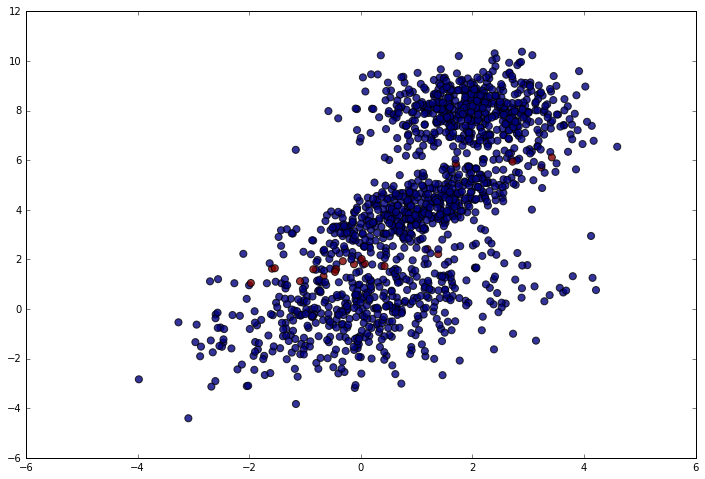

In [208]:
labels_flat = np.argmax(test_labels, axis = 1)
predictions = np.argmax(probs, axis = 1)
plt.figure(figsize = (12, 8))
plt.scatter(test_dataset[:, 0], test_dataset[:, 1], c = predictions == labels_flat - 1, alpha = .8, s = 50)

As expected, the model makes a few mistakes near the cluster boundaries, but does very well otherwise.

# Conclusion

Making this post was an unbelievable learning experience for me. I went from having a general understanding of neural networks to being able to write one entirely from scratch.

Am I going to consistently build standard networks from scratch? Absolutely not. But, without the foundation I developed from preparing for this blog post, I would have a much more difficult time trying to understand deeper and more complex networks.

Convolutional neural networks are one of those deeper and more complex networks. In two blog posts, I've now gone through image convolution and basic neural networks with a hidden layer. In the next post, I'll finally go through building a convolutional network.